In [1]:
%matplotlib notebook
from colicoords import load, CellPlot, CellListPlot, IterCellPlot, iter_subplots, save
import matplotlib.pyplot as plt
import numpy as np
import os
from collections import namedtuple
from tqdm.auto import tqdm

In [2]:
from scipy.signal import medfilt
from skimage.feature import peak_local_max

In [3]:
c41 = load('c41_binary_opt.hdf5')
epec = load('epec_binary_opt.hdf5')

<IPython.core.display.Javascript object>


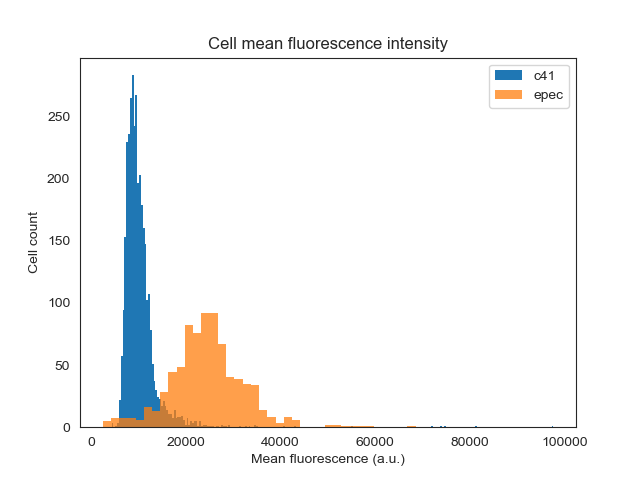

In [4]:
clp_c41 = CellListPlot(c41)
clp_epec = CellListPlot(epec)

fig, ax = plt.subplots()
clp_c41.hist_intensity(ax=ax, data_name='g500', linewidth=0, label='c41')
clp_epec.hist_intensity(ax=ax, data_name='g500', linewidth=0, label='epec', alpha=0.75)
plt.savefig('intensity comparison.png')
plt.legend()

In [5]:
storm_dtype = [('x', float), ('y', float), ('intensity', float), ('frame', int)]
def add_peakfind(cell, med=9, thd=7500, min_dst=5):
    img = cell.data.data_dict['g500']
    mf = medfilt(img, 9)
    img_bg = img - mf
    
    cell.data.add_data(img_bg, 'fluorescence', 'flu_mf')
    peaks = peak_local_max(img_bg, min_distance=min_dst, threshold_abs=thd)
    y, x = peaks.T
    
    new_storm = np.empty(len(x), dtype=storm_dtype)
    new_storm['x'] = x
    new_storm['y'] = y
    new_storm['intensity'] = np.ones_like(x)
    new_storm['frame'] = np.ones_like(x)
    
    cell.data.add_data(new_storm, 'storm', 'storm_thd_{}'.format(thd))

In [7]:
len(c41), len(epec)

(3408, 786)

In [6]:
c41_new = c41.copy()
[add_peakfind(c) for c in tqdm(c41_new)]

epec_new = epec.copy()
[add_peakfind(c) for c in tqdm(epec_new)]
''

''

<IPython.core.display.Javascript object>


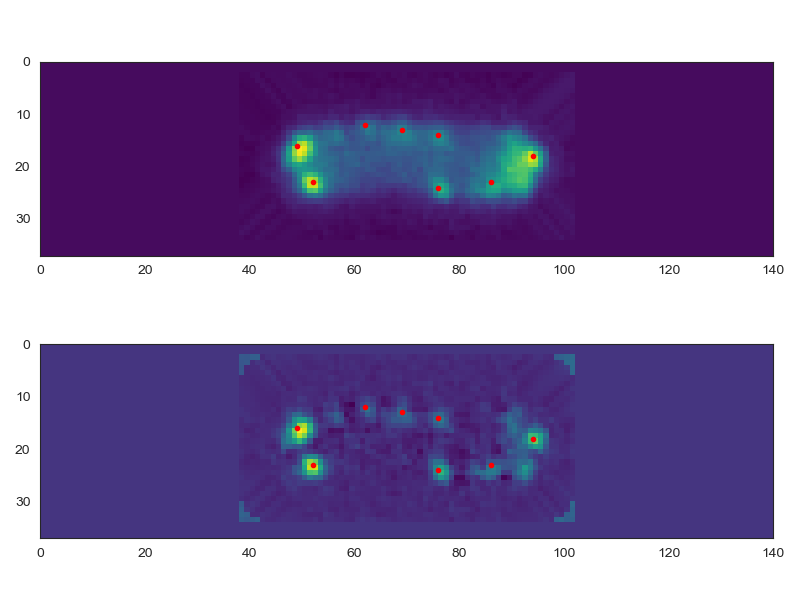

In [7]:
icp = IterCellPlot(epec_new)
fig, axes = iter_subplots(2, 1, figsize=(8,6))

icp.imshow('g500', ax=axes[0])
icp.plot_storm(data_name='storm_thd_7500', ax=axes[0])

icp.imshow('flu_mf', ax=axes[1])
icp.plot_storm(data_name='storm_thd_7500', ax=axes[1])

plt.tight_layout()
fig.display()

<IPython.core.display.Javascript object>


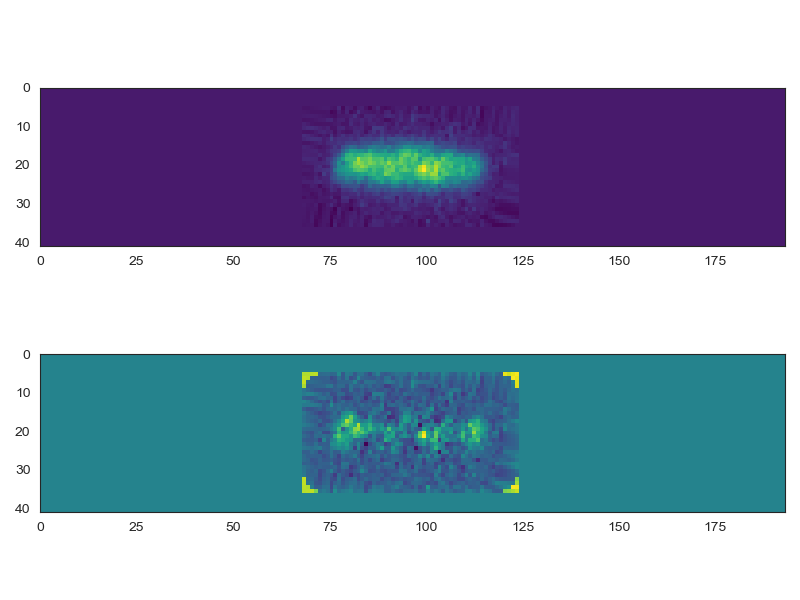

In [24]:
icp = IterCellPlot(c41_new)
fig, axes = iter_subplots(2, 1, figsize=(8,6))

icp.imshow('g500', ax=axes[0])
icp.plot_storm(data_name='storm_thd_7500', ax=axes[0])

icp.imshow('flu_mf', ax=axes[1])
icp.plot_storm(data_name='storm_thd_7500', ax=axes[1])

plt.tight_layout()
fig.display()

<IPython.core.display.Javascript object>


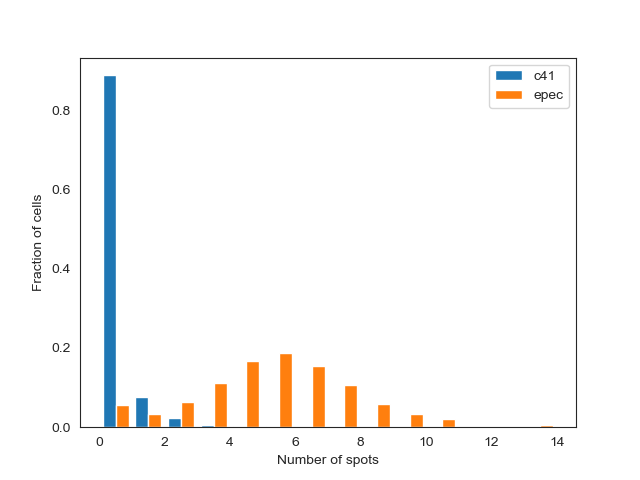

In [8]:
labels = ['c41', 'epec']
fig, ax = plt.subplots()
nums = []
for cells in [c41_new, epec_new]:
    num = [len(c.data.data_dict['storm_thd_7500']) for c in cells]
    nums.append(num)

ax.hist(nums, bins = np.arange(15), label=labels, density=True)

ax.legend()
    
#fig.text(0.04, 0.5, 'Number of spots', va='center', rotation='vertical')
plt.ylabel('Fraction of cells')
plt.xlabel('Number of spots')
plt.savefig('spots per cell_c41 epec.png')

In [9]:
save('c41_with_spots.hdf5', c41_new)
save('epec_with_spots.hdf5', epec_new)